In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

## Блок функций 

In [2]:
def output_unique_column_values(df, sign_list=[]):
    """
    Функция вывода уникальных значений признаков:
        df - Обязательный аргумент, перередавать DataFrame
        sign_list - Опцианальный аргумент, если аргумент не передается в функцию
            то выводяться уникальные значения всех признаком переданого датафрейма
        sign_list - В случаее передачи аргумента в виде строки str будут выведены
            уникальные значения данного признака в переданом датафрейме
        sign_list - В случае передачи списка признаков будут выведены уникальные значения 
            переданных признаков
    """
    
    if sign_list ==[]:
        sign_list = df.columns.tolist() 
        for sign in sign_list:
            print(f'{str(sign)}\n\n{str(df[sign].value_counts())}\n\n'
                  f'Length: {len(df[sign].value_counts())}\n{"*" * 100}\n')
    elif type(sign_list) is str: 
        print(f'{str(sign_list)}\n\n{str(df[sign_list].value_counts())}\n\n'
              f'Length: {len(df[sign_list].value_counts())}\n{"*" * 100}\n')
    else:
        for sign in sign_list:
            print(f'{str(sign)}\n\n{str(df[sign].value_counts())}\n\n'
                  f'Length: {len(df[sign].value_counts())}\n{"*" * 100}\n')
            

def preparation_signs_floor_housefloor(df, max_housefloor=55):
    """
    Функция подготовки признаков ['Floor'],['HouseFloor']:
        df - Обязательный аргумент, type(df): pandas.core.frame.DataFrame
        этаж (['Floor'] = 0)
            приравниваем к 1(=1)
        этаж больше этажности дома ['Floor'] > ['HouseFloor']
            (поменять местами ['Floor'], ['HouseFloor'] = ['HouseFloor'], ['Floor'])
        этажность дома (['HouseFloor'] = 0)|(['HouseFloor'] > 55) 
            приравниваем к этажу (=['Floor'])
        этаж (['Floor'] > 55) 
            приравниваем к этажности дома (=['HouseFloor'])      
    """
    df.loc[df.Floor==0,'Floor'] = 1
    id_row_0max_f = df.loc[(df.Floor > max_housefloor)].index .tolist()   
    df.loc[id_row_0max_f,'Floor'] = df.loc[id_row_0max_f,'HouseFloor']
    id_row_0max_hf = df.loc[(df.HouseFloor==0) | (df.HouseFloor > max_housefloor)].index.tolist() 
    df.loc[id_row_0max_hf,'HouseFloor'] = df.loc[id_row_0max_hf,'Floor']
    id_row_fhf = df.loc[df.Floor > df.HouseFloor].index.tolist() 
    df.loc[id_row_fhf,'Floor'], df.loc[id_row_fhf,'HouseFloor'] = df.loc[id_row_fhf,'HouseFloor'], df.loc[id_row_fhf,'Floor']    
    return df




def preparation_signs_square(df, max_sq=200):
    """
    Функция подготовки признаков [Square']:
        df - Обязательный аргумент, type(df): pandas.core.frame.DataFrame
        max_sq - порог максимального значение квадратуры площади
        true_data - выборка где количество комнат равны (1, 2, 3) и площадь меньше порога(default==200)
        med_sq - медианное значение ['Square'] в групировке по количеству комнат
        
        Значения где площадь больше порог(max_sq) и комнаты == (1, 2, 3) проходя в цикле заменяем на медианное значения 
            из выборки med_sq
    """
    true_data = df.loc[(df['Square'] < max_sq) & (df['Rooms'] > 0) & (df['Rooms'] < 4)]
    med_sq = true_data.groupby(['Rooms'])[['Square']].median() 
    for room in (1, 2, 3):
        df.loc[(df['Square'] > max_sq) & (df['Rooms'] == room),'Square'] = med_sq.loc[room,'Square']
    return df


def preparation_signs_lfsquare(df, min_lfsq=10):
    """
    Функция подготовки признаков ['LifeSquare']:
        df - Обязательный аргумент, type(df): pandas.core.frame.DataFrame
        min_lfsq - минимальное значение квадратуры жилой площади
        square_med_diff - мадианное значение разницы между признаками ['Square']['LifeSquare']['KitchenSquare']
        
        Заполнение пропущеных значений разницей признаков ['Square']['KitchenSquare'] и значения square_med_diff
    """
    df.loc[df.LifeSquare < min_lfsq, 'LifeSquare'] = min_lfsq
    square_med_diff = (df.loc[df.LifeSquare.notnull(), 'Square'] - \
                      df.loc[df.LifeSquare.notnull(), 'LifeSquare'] - \
                      df.loc[df.LifeSquare.notnull(), 'KitchenSquare']).mean()
    df.loc[df.LifeSquare.isnull(), 'LifeSquare'] = (df.loc[df.LifeSquare.isnull(), 'Square'] - \
                                                   df.loc[df.LifeSquare.isnull(), 'KitchenSquare'] - \
                                                   square_med_diff)
    
    return df


def preparation_signs_healthcare_1(df):
    """
    Функция подготовки признаков ['Healthcare_1']:
        df - Обязательный аргумент, type(df): pandas.core.frame.DataFrame
        dist_hc1 - медианное значение признака['Healthcare_1'] сгруппированного по признаку ['DistrictId']
        
        Пропущенные значения признака ['Healthcare_1'] в датафрейме dist_hc1 заполняются 
            средним значением по этому датафрейму(dist_hc1)
        В цикле проходим по индексам датафрейма dist_hc1 (в данном датафрейме индексом является признак ['DistrictId'])
            и заполняем пропущенные значения в датафрейме df по каждому дистрикту['DistrictId'] значением из dist_hc1
        возращаем датафрейм df
    """
        
    dist_hc1 = df.groupby(['DistrictId']
                         )[['Healthcare_1']].median()        
    dist_hc1.Healthcare_1 = dist_hc1.Healthcare_1.fillna(dist_hc1.Healthcare_1.mean())
    for dist in dist_hc1.index:
        df.loc[(df.Healthcare_1.isnull()) & (df.DistrictId == dist),'Healthcare_1'] = dist_hc1.loc[dist,'Healthcare_1']
    return df


def preparation_signs_ksquare(df, min_ksq=3, max_ksq=25):
    """
    Функция подготовки признаков ['KitchenSquare']:
        df - Обязательный аргумент, type(df): pandas.core.frame.DataFrame
        min_ksq - минимальное значение квадратуры кухни ['KitchenSquare'](default == 3)
        max_ksq - максимальное значение квадратуры кухни ['KitchenSquare'](default == 25)
        
        Если значения признака ['KitchenSquare'] в датафрейме df меньше min_ksq то 
            эти значения заменяются на min_ksq
        Если значения признака ['KitchenSquare'] в датафрейме df больше max_ksq то
            эти значения заменяются на медианое значения признака ['KitchenSquare'] в датафрейме df
        Возвращает датафрейм df
    """
        
    df.loc[df.KitchenSquare > max_ksq, 'KitchenSquare'] = df.KitchenSquare.median()
    df.loc[df.KitchenSquare < min_ksq, 'KitchenSquare'] = min_ksq
    return df


def preparation_signs_rooms(df, max_rooms=5):
    """
    Функция подготовки признаков ['Rooms']:    
        df - Обязательный аргумент, type(df): pandas.core.frame.DataFrame
        max_rooms - максимальное количество комнат(default==5)
        lfsq_room - среднее оношение жилой площади к количеству комнат, значения признака ['Rooms'] равные 0
            не учитываются(df.Rooms != 0)
        id_row - список индексов значений в датафрейме df удовлетворяющим условию что 
            значения признака ['Rooms'] равны 0  или больше значения max_rooms
            
        В датафрейме df значения попадающие в условие значения id_row заменяются на
            округленное значение отношения признака ['LifeSquare'] к значению lfsq_room
        Возвращаем датафрейм df
    """
    lfsq_room = (df.loc[df.Rooms!=0,'LifeSquare']/df.loc[df.Rooms!=0,'Rooms']).mean() 
    id_row = df.loc[(df.Rooms > max_rooms)|(df.Rooms == 0)].index.tolist()   
    df.loc[id_row, 'Rooms'] = round(df.loc[id_row,'LifeSquare']/lfsq_room)
    return df


def add_mean_square_by_distr_room(df, sign_list=['DistrictId','Rooms']):
    """
    Функция добавления признака['MeanSquare'] среднего значения квадратуры['Square'] 
        в зависимости от района и количества комнат:
        df - Обязательный аргумент, type(df): pandas.core.frame.DataFrame 
        sign_list - список признаков для групировки(default==['DistrictId','Rooms'])
        mean_square - Средняя площадь в зависимости от района и количества комнат
        
    """                                                                       
    mean_square = df.groupby(sign_list, as_index=False).agg({'Square':'mean'})\
                        .rename(columns={'Square':'MeanSquare'})                                                                                        
    df = df.merge(mean_square, on=sign_list, how='left')
    return df                                                                               
         

def add_med_price_by_distr(X, y, X_test, sign_list=['DistrictId','Rooms']):
    """
    Функция добавления признака['MedPriceByDistrict'] медианного значения цены 
        в зависимости от района и количества комнат:
        Принимает X(тренировочный датафрей за исключением целевого признака),
           y(целевой признак),
           X_test(тестовый датафрей) 
        - Обязательные аргумент, type( X, y, X_test ): pandas.core.frame.DataFrame 
        sign_list - список признаков для групировки(default==['DistrictId','Rooms'])
        df - датафрейм объедененый с целевым признаком 
        med_price_by_distr - медианное значение целевого значения в групировке по sign_list
        пропущеные значения в сгрупированой выборке заполняются медианным значением по df['MedPriceByDistrict']
        С тестовым датафреймом объеденяется признак ['MedPriceByDistrict'] созданный на тренировочном датафрейме
            пропущеные значения заполняются средним значением по X_test['MedPriceByDistrict']
       
    """
    df = X.join(y)
    med_price_by_distr = df.groupby(sign_list, as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict'})
    df = df.merge(med_price_by_distr, on=sign_list, how='left')
    df.MedPriceByDistrict = df.MedPriceByDistrict.fillna(df.MedPriceByDistrict.median())
    X_test = X_test.merge(med_price_by_distr, on=sign_list, how='left')
    med_test = X_test['MedPriceByDistrict'].median()
    X_test['MedPriceByDistrict'] = X_test['MedPriceByDistrict'].fillna(med_test)
    return df.drop('Price', axis=1), y, X_test


def add_mean_price_per_square_meter_by_distr(X, y, X_test, sign_list=['DistrictId']):
    """
    Функция добавления признака['MeanPricePerSquareMeter'] среднего значения отношения цены к квадратуре 
        в зависимости от района:
        Принимает X(тренировочный датафрей за исключением целевого признака),
           y(целевой признак),
           X_test(тестовый датафрей) 
        - Обязательные аргумент, type( X, y, X_test ): pandas.core.frame.DataFrame 
        sign_list - список признаков для групировки(default==['DistrictId'])
        df - датафрейм объедененый с целевым признаком 
        mean_price_per_square_meter - среднее значение отношения цены к площади['MeanPricePerSquareMeter']
        пропущеные значения в сгрупированой выборке заполняются средним значением по df['MeanPricePerSquareMeter']
        С тестовым датафреймом объеденяется признак ['MeanPricePerSquareMeter'] созданный на тренировочном датафрейме
            пропущеные значения заполняются средним значением по X_test['MeanPricePerSquareMeter']
    """
    df = X.join(y)
    df['PricePerSquareMeter'] = df['Price']/df['Square']
    mean_price_per_square_meter = df.groupby(sign_list, as_index=False).agg({'PricePerSquareMeter':'mean'}).rename(columns={'PricePerSquareMeter':'MeanPricePerSquareMeter'})
    df = df.merge(mean_price_per_square_meter, on=sign_list, how='left').drop('PricePerSquareMeter', axis=1)  
    df.MeanPricePerSquareMeter = df.MeanPricePerSquareMeter.fillna(df.MeanPricePerSquareMeter.mean())
    X_test = X_test.merge(mean_price_per_square_meter, on=sign_list, how='left')
    mean_test = X_test['MeanPricePerSquareMeter'].mean()
    X_test['MeanPricePerSquareMeter'] = X_test['MeanPricePerSquareMeter'].fillna(mean_test)
    return df.drop('Price', axis=1), y, X_test                                                                     
                                                                                
    
def preparation_data(X_train, y_train,  X_test):
    """
    Функция подготовки данных тренировочного и тестого датафреймов:
        X_train - Тренировочный датафрейм за исключением целевого признака,
        y_train - Целевой признак тренировочного датафрейма,
        X_test - Тестовый датафрейм
        
        preparation_signs_floor_housefloor - Функция подготовки признаков ['Floor'],['HouseFloor']
        preparation_signs_ksquare - Функция подготовки признаков ['KitchenSquare']
        preparation_signs_lfsquare - Функция подготовки признаков ['LifeSquare']
        preparation_signs_rooms - Функция подготовки признаков ['Rooms']
        preparation_signs_healthcare_1 - Функция подготовки признаков ['Healthcare_1']
        preparation_signs_square - Функция подготовки признаков [Square']
        add_mean_square_by_distr_room - Функция добавления признака['MeanSquare'] 
            среднего значения квадратуры['Square'] в зависимости от района и количества комнат
        add_med_price_by_distr - Функция добавления признака['MedPriceByDistrict'] 
            медианного значения цены в зависимости от района и количества комнат        
        add_mean_price_per_square_meter_by_distr - Функция добавления признака['MeanPricePerSquareMeter']
            среднего значения отношения цены к квадратуре в зависимости от района
    """
    X_train, X_test = preparation_signs_floor_housefloor(X_train), preparation_signs_floor_housefloor(X_test)
    X_train, X_test = preparation_signs_ksquare(X_train), preparation_signs_ksquare(X_test)
    X_train, X_test = preparation_signs_lfsquare(X_train), preparation_signs_lfsquare(X_test)
    X_train, X_test = preparation_signs_rooms(X_train), preparation_signs_rooms(X_test)
    X_train, X_test = preparation_signs_healthcare_1(X_train), preparation_signs_healthcare_1(X_test)
    X_train, X_test = add_mean_square_by_distr_room(X_train), add_mean_square_by_distr_room(X_test) 
    X_train, X_test = preparation_signs_square(X_train), preparation_signs_square(X_test)
    X_train, y_train, X_test = add_med_price_by_distr(X_train, y_train, X_test)
    X_train, y_train, X_test = add_mean_price_per_square_meter_by_distr(X_train, y_train, X_test)
    return X_train, y_train, X_test
    

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    Принимает значения тренировочных и тестовых векторов целевых переменых 
        истинных(_true_values) и предсказаных(_pred_values)
    выводит: метрику r2 для тренировочных и тестовых данных,
        и два scatterplot графика для тренировочных и тестовых данных
    
    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Блок загрузки и обзор описания данных

In [3]:
TRAIN = 'train.csv'
TEST = 'test.csv'

In [4]:
train_df = pd.read_csv(TRAIN)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [5]:
test_df = pd.read_csv(TEST)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [6]:
train_df.shape[1] == test_df.shape[1]+1

True

### Обзор информации о данных
#### Приведение типов

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Замена типов данных признаков Id, DistrictId на str (категориальные данные) для данных из выборок train_df, test_df

In [8]:
train_df.Id = train_df.Id.astype(str)
train_df.DistrictId = train_df.DistrictId.astype(str)
test_df.Id = test_df.Id.astype(str)
test_df.DistrictId = test_df.DistrictId.astype(str)

In [9]:
train_df.dtypes.value_counts()

float64    8
int64      7
object     5
dtype: int64

In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   object 
 1   DistrictId     5000 non-null   object 
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [11]:
test_df.dtypes.value_counts()

float64    7
int64      7
object     5
dtype: int64

#### Описание датасета по уникальным значениям признаков
 - Идентификационный номер квартиры 
* Id, Length: 10000
 - Идентификационный номер района
* DistrictId, Length: 205 
 - Количество комнат
* Rooms, Length: 9 
 - Площадь 
* Square, Length: 10000 
 - Жилая площадь
* LifeSquare, Length: 7887 
 - Площадь кухни
* KitchenSquare, Length: 58 
 - Этаж
* Floor, Length: 33 
 - Количество этажей в доме
* HouseFloor, Length: 44 
 - Год постройки дома
* HouseYear, Length: 97 
 - Экологические показатели местности
*     Ecology_1, Length: 129
*     Ecology_2, Length: 2
*     Ecology_3, Length: 2
 - Социальные показатели местности
*     Social_1, Length: 51
*     Social_2, Length: 142
*     Social_3, Length: 30
 - Показатели местности, связанные с охраной здоровья
*     Healthcare_1, Length: 79
*     Helthcare_2, Length: 7
 - Показатели, связанные с наличием магазинов, торговых центров
* Shops_1, Length: 16
* Shops_2, Length: 2
 - Цена квартиры
* Price, Length: 10000 

In [12]:
# output_unique_column_values(train_df)

### Подготовка данных

Обработка признака ['HouseYear']: 'Год постройки дома'

In [13]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [14]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [15]:
train_df.loc[(train_df.HouseYear > 2020)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


In [16]:
train_df.loc[1497, 'HouseYear'] = 2011
train_df.loc[4189, 'HouseYear'] = 1968
train_df.loc[[1497, 4189]]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,2011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,1968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


In [17]:
test_df.loc[(test_df.HouseYear > 2020)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2


Обработка признака ['HouseFloor'], ['Floor']: 'Количество этажей в доме', 'Этаж'

Обработка признака ['KitchenSquare'], ['LifeSquare']: 'Площадь кухни', 'Жилая площадь'

Обработка признака ['Rooms']: 'Количество комнат'

Обработка признака ['Healthcare_1']: 'Показатели местности, связанные с охраной здоровья'

Обработка признака ['Square']: 'Площадь'

### Создание дополнительных признаков

add_mean_square_by_distr_room - Функция добавления признака['MeanSquare'] 
    среднего значения квадратуры['Square'] в зависимости от района и количества комнат
    
add_med_price_by_distr - Функция добавления признака['MedPriceByDistrict'] 
    медианного значения цены в зависимости от района и количества комнат        
    
add_mean_price_per_square_meter_by_distr - Функция добавления признака['MeanPricePerSquareMeter']
    среднего значения отношения цены к квадратуре в зависимости от района

### Применение функций подготовки данных к тренировочному и тестовому датафрейму

In [18]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
                 'HouseYear', 'Social_1', 'Social_2', 'Social_3', 'Ecology_1',
                 'MeanPricePerSquareMeter', 'MedPriceByDistrict', 'MeanSquare']
target_name = 'Price'
X = train_df.drop(target_name, axis=1)
y = pd.DataFrame(train_df[target_name])
X, y, test_df = preparation_data(X, y, test_df)
X = X[feature_names]
X.tail()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Social_1,Social_2,Social_3,Ecology_1,MeanPricePerSquareMeter,MedPriceByDistrict,MeanSquare
9995,2.0,50.401785,30.476203,5.0,5.0,6.0,1968,46,7960,6,0.135650,5008.861902,233599.115975,49.441973
9996,1.0,41.521546,20.539216,9.0,13.0,13.0,2000,30,5562,0,0.000000,3884.193541,171162.179903,40.667248
9997,1.0,47.939008,34.248026,3.0,12.0,16.0,2015,2,629,1,0.072158,2912.252253,118309.315585,42.632304
9998,2.0,43.602562,33.840147,8.0,1.0,5.0,1961,30,5048,9,0.307467,4207.483727,187966.419078,51.867999
9999,1.0,38.666645,21.157874,8.0,7.0,17.0,1990,27,4798,0,0.000000,4312.127855,178780.606244,40.454972


### Стандартизация признаков

#### Стандартизация тренировочных данных

In [19]:
feature_names_for_stand = X[feature_names].select_dtypes(include='float64').columns.tolist()
scaler = StandardScaler()
stand_features = scaler.fit_transform(X[feature_names_for_stand])
X[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)
X.tail()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Social_1,Social_2,Social_3,Ecology_1,MeanPricePerSquareMeter,MedPriceByDistrict,MeanSquare
9995,0.135406,-0.300987,-0.113265,-0.454376,-0.562983,-1.258871,1968,46,7960,6,0.141089,1.007452,0.288444,-0.418212
9996,-1.088879,-0.764726,-0.241755,0.854122,0.967278,-0.069028,2000,30,5562,0,-0.998641,-0.103650,-0.527078,-0.952080
9997,-1.088879,-0.429597,-0.064494,-1.108625,0.775996,0.440905,2015,2,629,1,-0.392373,-1.063867,-1.217417,-0.832523
9998,0.135406,-0.656052,-0.069768,0.526998,-1.328114,-1.428849,1961,30,5048,9,1.584694,0.215741,-0.307589,-0.270609
9999,-1.088879,-0.913812,-0.233756,0.526998,-0.180418,0.610883,1990,27,4798,0,-0.998641,0.319123,-0.427570,-0.964995


#### Стандартизация тестовых данных

In [20]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
                 'HouseYear', 'Social_1', 'Social_2', 'Social_3', 'Ecology_1',
                 'MeanPricePerSquareMeter', 'MedPriceByDistrict', 'MeanSquare']

feature_names_for_stand_test = test_df[feature_names].select_dtypes(include='float64').columns.tolist()
stand_features = scaler.fit_transform(test_df[feature_names_for_stand_test])
test_df[feature_names_for_stand_test] = pd.DataFrame(stand_features, columns=feature_names_for_stand_test)
test_df[feature_names].tail()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Social_1,Social_2,Social_3,Ecology_1,MeanPricePerSquareMeter,MedPriceByDistrict,MeanSquare
4995,1.350456,0.565316,0.696925,-0.126903,-0.572936,-0.722463,1973,36,5992,0,-0.997055,0.050580,0.500402,0.801993
4996,-1.122454,-0.856031,-0.899525,1.212444,0.727671,0.600850,2017,1,264,0,-0.939144,-0.482942,-0.889623,-0.816189
4997,1.350456,1.130378,0.557817,0.877607,2.585682,1.593335,1989,74,19083,2,-0.242173,0.101138,1.438587,1.038859
4998,0.114001,1.313118,1.554175,-1.131414,-0.758737,-1.549533,1977,2,629,1,-0.397445,-1.187542,-0.443126,0.556609
4999,0.114001,0.218192,0.412021,-1.131414,0.356069,0.600850,1977,22,6398,141,-0.997817,-1.158866,-0.456901,0.384963


### Разбиение на train и test

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [22]:
X_train.isnull().sum()

Rooms                      0
Square                     0
LifeSquare                 0
KitchenSquare              0
Floor                      0
HouseFloor                 0
HouseYear                  0
Social_1                   0
Social_2                   0
Social_3                   0
Ecology_1                  0
MeanPricePerSquareMeter    0
MedPriceByDistrict         0
MeanSquare                 0
dtype: int64

In [23]:
X_test.isnull().sum()

Rooms                      0
Square                     0
LifeSquare                 0
KitchenSquare              0
Floor                      0
HouseFloor                 0
HouseYear                  0
Social_1                   0
Social_2                   0
Social_3                   0
Ecology_1                  0
MeanPricePerSquareMeter    0
MedPriceByDistrict         0
MeanSquare                 0
dtype: int64

## Построение модели

In [24]:
rf_model = RandomForestRegressor(random_state=42, max_features=5, max_depth=13, n_estimators=425)


**Обучение и оценка модели**

In [25]:
rf_model.fit(X, y)
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

Train R2:	0.931
Test R2:	0.929


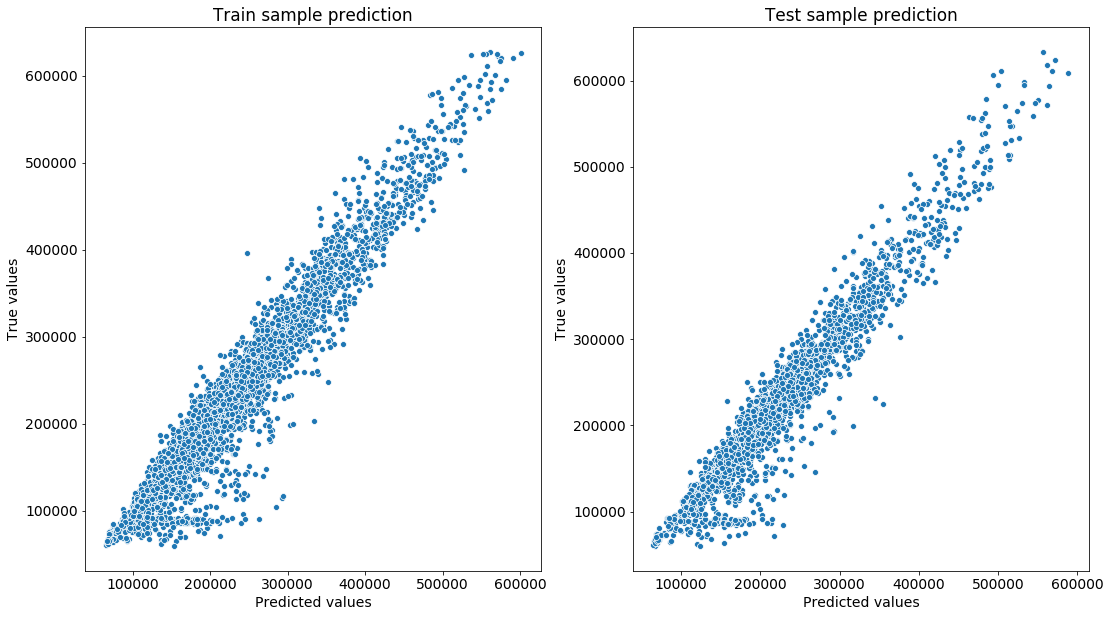

In [26]:
evaluate_preds(y_train.values[:, 0], y_train_preds, y_test.values[:, 0], y_test_preds)

### Крос валидация

In [27]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.74870691, 0.76545885, 0.77231972, 0.77109164, 0.80239771])

#### Ожидаемые показания на предсказания цены для test.csv

In [28]:
cv_score.mean(), cv_score.std()

(0.7719949632722629, 0.017379889876961454)

In [29]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.7546150733953014, 0.7893748531492244)

#### Оценка важности признаков

In [30]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

sort_feature_importances = feature_importances.sort_values(by='importance', ascending=False)
sort_feature_importances

,feature_name,importance
12,MedPriceByDistrict,0.341863
1,Square,0.192948
11,MeanPricePerSquareMeter,0.109507
13,MeanSquare,0.060994
0,Rooms,0.055888
2,LifeSquare,0.045966
8,Social_2,0.031758
3,KitchenSquare,0.029682
7,Social_1,0.028592
6,HouseYear,0.027838


In [31]:
print(f'Cумма важности первых 6 признаков: {sum(sort_feature_importances.importance.head(6))}')

Cумма важности первых 6 признаков: 0.8071661403224902


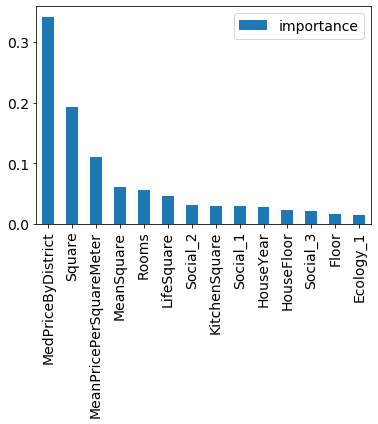

In [32]:
sort_feature_importances.reset_index(drop=True).plot(kind="bar")
plt.xticks(
    ticks=range(sort_feature_importances.shape[0]), 
    labels=sort_feature_importances.feature_name,
    size=14
)
plt.show()

#### Сравнение моделей RandomForestRegressor и GradientBoostingRegressor

In [33]:
gb_model = GradientBoostingRegressor(max_depth=6, n_estimators=101,random_state=42, max_features=6)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=6, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=101,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Train R2:	0.912
Test R2:	0.766


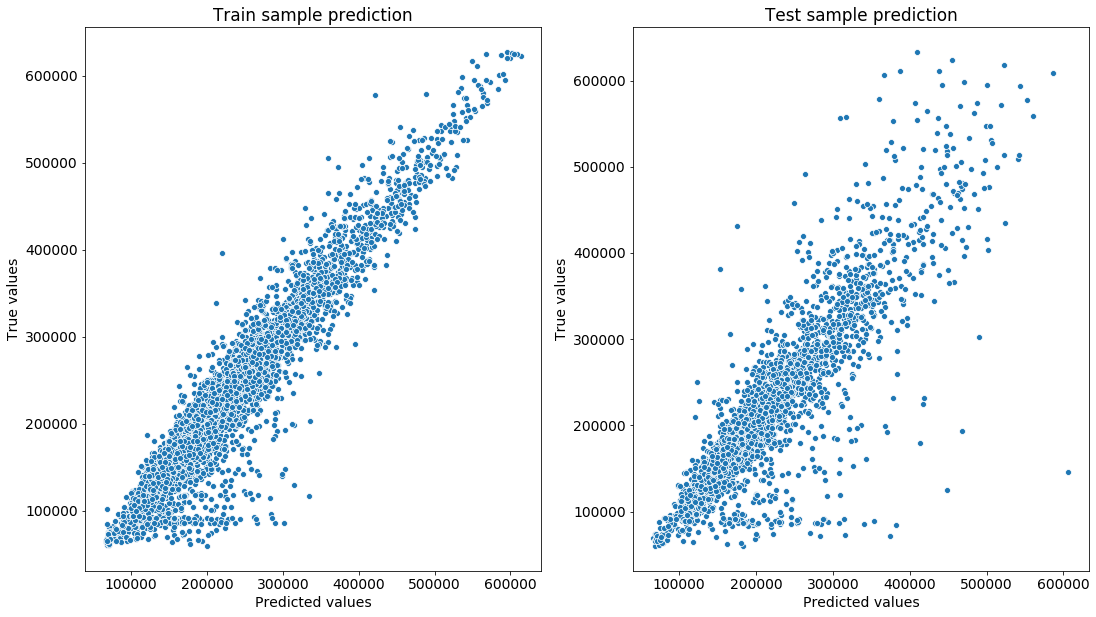

In [34]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_train.values[:, 0], y_train_preds, y_test.values[:, 0], y_test_preds,)

## Предсказание цены на данных test.csv

In [35]:
test_df['Price'] = rf_model.predict(test_df[feature_names])

In [36]:
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,MeanSquare,MedPriceByDistrict,MeanPricePerSquareMeter,Price
4995,8180,11,1.350456,0.565316,0.696925,-0.126903,-0.572936,-0.722463,1973,-0.997055,...,5992,0,1015.000000,1,1,B,0.801993,0.500402,0.050580,244019.845280
4996,4695,1,-1.122454,-0.856031,-0.899525,1.212444,0.727671,0.600850,2017,-0.939144,...,264,0,240.000000,0,1,B,-0.816189,-0.889623,-0.482942,127438.174540
4997,5783,12,1.350456,1.130378,0.557817,0.877607,2.585682,1.593335,1989,-0.242173,...,19083,2,1519.003145,5,15,B,1.038859,1.438587,0.101138,331458.223566
4998,4780,62,0.114001,1.313118,1.554175,-1.131414,-0.758737,-1.549533,1977,-0.397445,...,629,1,2300.000000,0,0,A,0.556609,-0.443126,-1.187542,211448.610477
4999,12504,30,0.114001,0.218192,0.412021,-1.131414,0.356069,0.600850,1977,-0.997817,...,6398,141,1046.000000,3,23,B,0.384963,-0.456901,-1.158866,182150.563712


### Осмотр данных для сохранения

In [37]:
test_df[['Id','Price']].tail()

,Id,Price
4995,8180,244019.845280
4996,4695,127438.174540
4997,5783,331458.223566
4998,4780,211448.610477
4999,12504,182150.563712


### Сохранение данных

In [38]:
test_df[['Id','Price']].to_csv('GlukharevOlegAnatolyevich_predictions.csv', index=None)